In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre
import matplotlib

In [44]:
# Jonah's conventions for the unit cell and stuff
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = -q3 # The K point
gpt = np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = -q3 - 0.5*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w0 = 0.05/np.sqrt(3)
w1 = 0.8/np.sqrt(3)
vFkth = 110.0*np.sqrt(3)

In [45]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2)
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega)
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

In [46]:
def distance(a,b): # finds the distance between two complex vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [47]:
formFactors1 = np.load('TBG_Form_Factors_G1.npy')
formFactors2 = np.load('TBG_Form_Factors_G2.npy')

def calculateMatrixElement1(k,m,n):
    G1 = 1.
    G2 = 0. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors1[m][n])

def calculateMatrixElement2(k,m,n):
    G1 = 0.
    G2 = 1. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors2[m][n])

In [48]:
# First calculate the t-matrices, which do not change for different k-points, and kinetic terms

num_landau = 80
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# The second kinetic term is more complicated    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 0.5j*np.sign(m)*coeff
            kinetic_1[m][n] = -0.5j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -0.5j*np.sign(n)*coeff
            kinetic_1[m][n] = 0.5j*np.sign(n)*coeff

# now the T-matrices, but the k-dependence is factored out
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat.conj().T], [t_mat, kinetic_2]])
    return(vFkth*hamiltonian)

In [49]:
# create the Z_matrix
num_landau = 80
z1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
z2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
zeros = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m) == abs(n)+1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            z2_matrix[m][n] += z2*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff
            z2_matrix[m][n] += z2bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff

z1_total_mat = np.block([[z1_matrix,zeros],[zeros,z1_matrix]])
z2_total_mat = np.block([[z2_matrix,zeros],[zeros,z2_matrix]])

In [50]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
g_to_k = [gpt * (1.0 - (t+0.0)/numpoints) + kpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
k_to_m = [kpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
g_to_mm = [gpt * (1.0 - (t+0.0)/numpoints) + mmpt * ((t+0.0)/numpoints) for t in range(numpoints)]
mm_to_kp = [mmpt * (1.0 - (t+0.0)/numpoints) + kppt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = g_to_k+k_to_m+m_to_g+g_to_mm+mm_to_kp # + means append here, so the list is 3*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [38]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

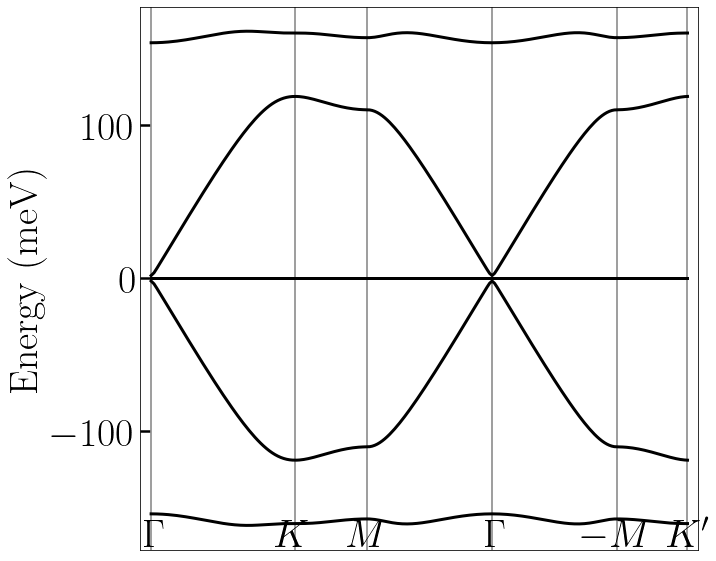

In [39]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)


plt.figure(figsize=(10,10))
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
plt.axvline(x=len_k[0],color='gray')
plt.text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
plt.axvline(x=len_k[50],color='gray')
plt.text(len_k[50]-.15,-175,r'$K$',rotation=0)
plt.axvline(x=len_k[100],color='gray')
plt.text(len_k[100]-.15,-175,r'$M$',rotation=0)
plt.axvline(x=len_k[150],color='gray')
plt.text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
plt.axvline(x=len_k[200],color='gray')
plt.text(len_k[200]-.25,-175,r'$-M$',rotation=0)
plt.axvline(x=len_k[249],color='gray')
plt.text(len_k[249]-.15,-175,r"$K'$",rotation=0)

plt.xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

plt.ylabel(r'Energy (meV)')
for i in range(158,164):
    plt.plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')

plt.tick_params(direction="in",width=2.5, length=10)
#plt.savefig('TBG_In_Flux_chiral_phase.pdf',bbox_inches='tight')

In [51]:
def getWilsonSpectrum(path):
    k_old = path[0]
    for j1, k_vec in enumerate(path):
        k_diff = k_vec-k_old
        k1 = np.dot(k_diff,a1)
        k2 = np.dot(k_diff,a2)
        
        expm_mat = sp.linalg.expm(-1.0j*2*np.pi*(k1*z2_total_mat - k2*z1_total_mat))
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        u_matrix_p1 = eigenvecs[:,162]
        u_matrix_p2 = eigenvecs[:,163]
        u_matrix_m1 = eigenvecs[:,159]
        u_matrix_m2 = eigenvecs[:,158]
        
        if j1 == 0:
            w_last_p1 = u_matrix_p1
            w_first_p1 = u_matrix_p1.conj().T
            w_last_p2 = u_matrix_p2
            w_first_p2 = u_matrix_p2.conj().T
            w_last_m1 = u_matrix_m1
            w_first_m1 = u_matrix_m1.conj().T
            w_last_m2 = u_matrix_m2
            w_first_m2 = u_matrix_m2.conj().T
            w_last = u_matrix
            w_first = u_matrix.conj().T            
            
        else:
            w_first = np.dot(np.dot(np.dot(w_first,expm_mat), u_matrix),u_matrix.conj().T)
            w_first_p1 = np.dot(np.dot(np.dot(w_first_p1,expm_mat), u_matrix_p1),u_matrix_p1.conj().T)
            w_first_p2 = np.dot(np.dot(np.dot(w_first_p2,expm_mat), u_matrix_p2),u_matrix_p2.conj().T)
            w_first_m1 = np.dot(np.dot(np.dot(w_first_m1,expm_mat), u_matrix_m1),u_matrix_m1.conj().T)
            w_first_m2 = np.dot(np.dot(np.dot(w_first_m2,expm_mat), u_matrix_m2),u_matrix_m2.conj().T)
        
        k_old = k_vec
        
    return(np.dot(w_first,w_last),np.dot(w_first_p1,w_last_p1),np.dot(w_first_p2,w_last_p2),\
            np.dot(w_first_m1,w_last_m1),np.dot(w_first_m2,w_last_m2))

In [52]:
path_k1 = [[b1*(j)/150.0+(b2)*i/150.0 for i in range(150)] for j in range(151)]
path_k2 = [[b2*j/50.0+b1*i/50.0 for i in range(50)] for j in range(50)]
path_y = [[b1*(j)/50.0+(b1+b2)*i/50.0 for i in range(50)] for j in range(50)]
path_x = [[b1*j/50.0+(b1-b2)*i/50.0 for i in range(50)] for j in range(50)]

In [53]:
midpoints1 = [(q1+q2)*(1.-i/50.0) for i in range(50)]
midpoints2 = [(q3+q2)*i/50.0 for i in range(50)]
midpoints3 = [(q3+q1)*i/50.0 for i in range(50)]

In [54]:
# generate the C3 invariant paths

path_list=[]
for j in range(50): # first 50 paths
    pt1 = [q2*(1.-i/50.0) + midpoints1[j]*i/50.0 for i in range(50)]+[midpoints1[j]*(1.-i/50.0) + q1*i/50.0 for i in range(50)]
    path_list.append(pt1)
    
for j in range(50): # next 50 paths
    pt1 = [q2*(1.-i/50.0) + midpoints2[j]*i/50.0 for i in range(50)]+[midpoints2[j]*(1.-i/50.0) + q3*i/50.0 for i in range(50)]
    pt2 = [q3*(1.-i/50.0) + midpoints3[j]*i/50.0 for i in range(50)]+[midpoints3[j]*(1.-i/50.0) + q1*i/50.0 for i in range(50)]
    path_list.append(pt1+pt2)

In [55]:
listOfEigvalsWilson = []
listOfwMp1 = []
listOfwMp2 = []
listOfwMm1 = []
listOfwMm2 = []

for path in path_k1:
    wilsonMatrix,wMp1,wMp2,wMm1,wMm2 = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    listOfwMp1.append(-1.0j*np.log(wMp1))
    listOfwMp2.append(-1.0j*np.log(wMp2))
    listOfwMm1.append(-1.0j*np.log(wMm1))
    listOfwMm2.append(-1.0j*np.log(wMm2))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
arrayOfwMp1 = np.array(listOfwMp1)
arrayOfwMp2 = np.array(listOfwMp2)
arrayOfwMm1 = np.array(listOfwMm1)
arrayOfwMm2 = np.array(listOfwMm2)

#plt.figure(figsize=(10,10))

#for i in range(2):
#    plt.scatter(range(50), arrayOfEigvalsWilson[:,i],s=4)    

In [56]:
np.save('path_k1_flat_B.npy',arrayOfEigvalsWilson)
np.save('path_k1_p1_B.npy',arrayOfwMp1)
np.save('path_k1_p2_B.npy',arrayOfwMp2)
np.save('path_k1_m1_B.npy',arrayOfwMm1)
np.save('path_k1_m2_B.npy',arrayOfwMm2)

In [12]:
arrayOfEigvalsWilson = np.load('path_k1_flat_chiral.npy')
arrayOfwMp1 = np.load('path_k1_p1_chiral.npy')
arrayOfwMp2 = np.load('path_k1_p2_chiral.npy')
arrayOfwMm1 = np.load('path_k1_m1_chiral.npy')
arrayOfwMm2 = np.load('path_k1_m2_chiral.npy')

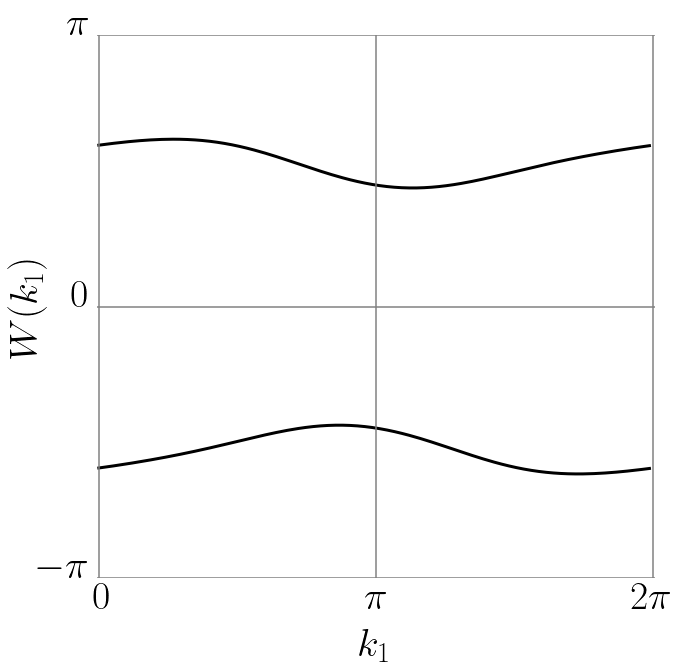

In [13]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)


plt.figure(figsize=(10,10))
frame1 = plt.gca()
plt.tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
plt.tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0]) + np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1]) + np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)

v0 = np.zeros(150)
v1 = np.zeros(150)

for i in range(150):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

plt.plot(range(150), v0,c='black',linewidth=3) 
plt.plot(range(150), v1,c='black',linewidth=3) 


plt.axhline(y=0,color='gray')
plt.axhline(y=np.pi,color='gray')
plt.axhline(y=2*np.pi,color='gray')

plt.text(-16.75,0,r'$-\pi$',rotation=0)
plt.text(-7.5,np.pi,r'$0$',rotation=0)
plt.text(-8.5,2*np.pi,r'$\pi$',rotation=0)

plt.axvline(x=0,color='gray')
plt.axvline(x=75,color='gray')
plt.axvline(x=150,color='gray')

plt.text(0-1.5,-0.35,r'$0$',rotation=0)
plt.text(75-3,-0.35,r'$\pi$',rotation=0)
plt.text(150-6,-0.35,r'$2\pi$',rotation=0)
plt.xlim([-0.5,150.5])
plt.ylim([0,2*np.pi])

plt.ylabel(r'$W(k_1)$',labelpad=50)
plt.xlabel(r'$k_1$',labelpad=50)
ax = plt.subplot(111)
ax.set_frame_on(False)
plt.tick_params(left=False)

plt.savefig('alongk1Changed_flat_A.pdf')

In [16]:
totalEigs = []
for i in range(150):
    for j in range(150):
        k_vec = b1*j/150.0+b2*i/150.0
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        totalEigs.append(eigenvals[158:164])        

In [17]:
total = np.array(totalEigs).flatten()

In [18]:
total

array([-97.51414376, -73.67869871,  -1.0176809 , ...,   1.01529183,
        73.63820412,  97.55880445])

In [19]:
np.save('histogram_data.npy',total)

In [14]:
total = np.load('histogram_data.npy')

In [15]:
a, b = np.histogram(total, bins=200)

In [16]:
q = b[:200] + np.diff(b)/2.0

In [17]:
b[0]-np.diff(b)[0]/2.0

-137.078946495707

In [18]:
b[-1]+np.diff(b)[0]/2.0

137.07894649570716

In [19]:
np.diff(b)[3]*sum(a)

184135.89827781564

In [20]:
sum(a)

135000

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


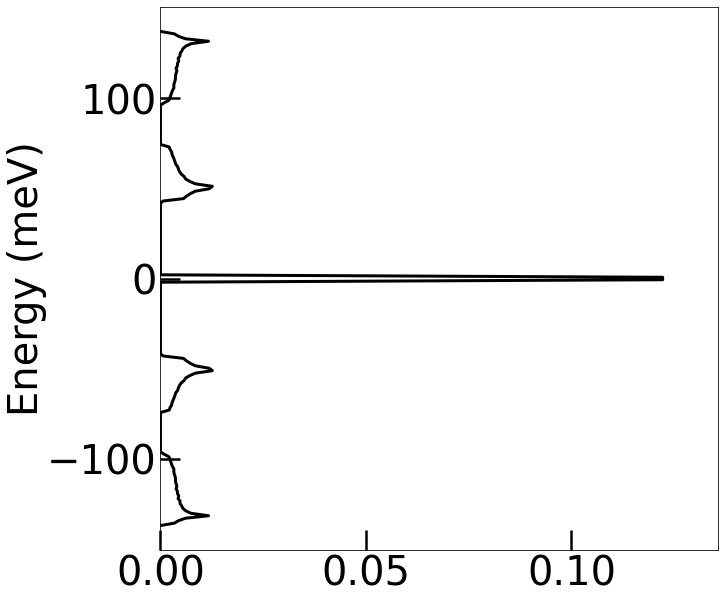

In [18]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
#matplotlib.rc('text',usetex=True)
plt.figure(figsize=(10,10))
frame1 = plt.gca()

plt.xlim([0,25000/184135.89827781564])
plt.ylabel('Energy (meV)',labelpad=0)

ap = np.concatenate(([0],a,[0]))
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))


plt.plot(ap/184135.89827781564, qp, linewidth=3, color='black')
plt.tick_params(direction="in",width=2.5, length=20)

plt.savefig('Phase_A_histogram.pdf',bbox_inches='tight')

In [77]:
max(a)

22500

Text(0.025, -130, 'D.O.S.')

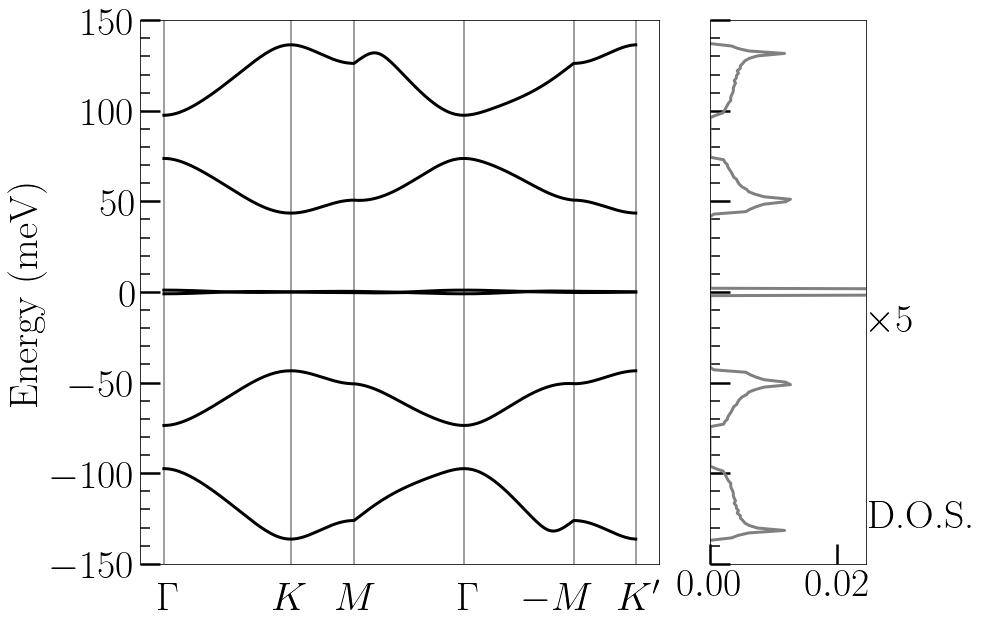

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 10), gridspec_kw={'width_ratios': [1,0.3]})
plt.subplots_adjust(wspace=0.15)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.15,-175,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.15,-175,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-.4,-175,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-.15,-175,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
for i in range(158,164):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    
    
ap = np.concatenate(([0],a,[0]))/184135.89827781564
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))


axes[1].plot(ap, qp, linewidth=3, color='gray')
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 4500/184136])
axes[1].set_ylim([-150, 150])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.025,-20,r"$\times 5$",rotation=0)
axes[1].text(0.025,-130,r"D.O.S.",rotation=0)



#plt.savefig('Phase_A.pdf',bbox_inches='tight')

In [23]:
import pandas as pd
df = pd.read_csv("TBGhofdata.csv")


In [42]:
from matplotlib.ticker import FuncFormatter
def my_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str

major_formatter = FuncFormatter(my_formatter)


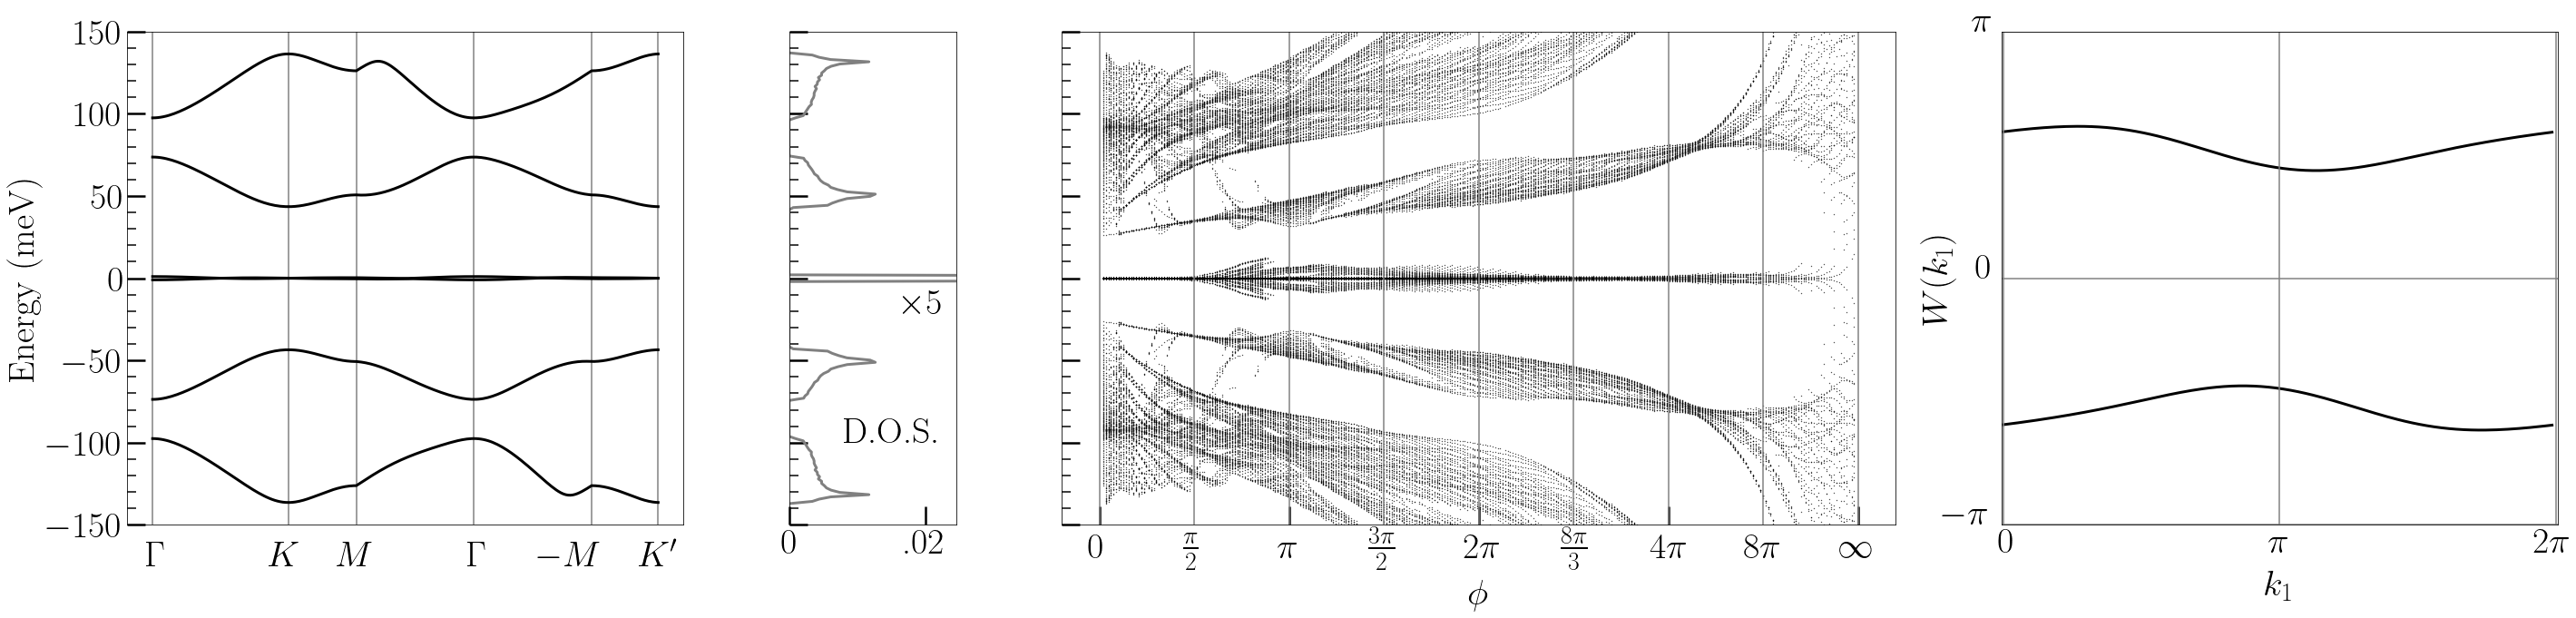

In [46]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(48, 10), gridspec_kw={'width_ratios': [1,0.3,1.5,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.15,-175,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.15,-175,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-.4,-175,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-.15,-175,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
for i in range(158,164):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    
    
ap = np.concatenate(([0],a,[0]))/184135.89827781564
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))


axes[1].plot(ap, qp, linewidth=3, color='gray')
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 4500/184136])
axes[1].set_ylim([-150, 150])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.0165,-20,r"$\times 5$",rotation=0)
axes[1].text(0.008,-100,r"D.O.S.",rotation=0)
axes[1].xaxis.set_major_formatter(major_formatter)

axes[2].axvline(x=0,color='gray')
axes[2].axvline(x=0.25,color='gray')
axes[2].axvline(x=0.5,color='gray')
axes[2].axvline(x=0.75,color='gray')
axes[2].axvline(x=1,color='gray')

axes[2].axvline(x=1.25,color='gray')
axes[2].axvline(x=1.5,color='gray')
axes[2].axvline(x=1.75,color='gray')
axes[2].axvline(x=2,color='gray')

axes[2].text(0-0.03,-170,r'$0$',rotation=0)
axes[2].text(0.25-0.03,-170,r'$\frac{\pi}{2}$',rotation=0)
axes[2].text(0.5-0.03,-170,r'$\pi$',rotation=0)
axes[2].text(0.75-0.04,-170,r'$\frac{3\pi}{2}$',rotation=0)
axes[2].text(1-0.04,-170,r'$2\pi$',rotation=0)
axes[2].text(1.25-0.035,-170,r'$\frac{8\pi}{3}$',rotation=0)
axes[2].text(1.5-0.05,-170,r'$4\pi$',rotation=0)
axes[2].text(1.75-0.05,-170,r'$8\pi$',rotation=0)
axes[2].text(2-0.05,-170,r'$\infty$',rotation=0)

axes[2].set_ylim([-150, 150])
axes[2].get_yaxis().set_ticklabels([])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

#axes.set_ylabel(r'Energy (meV)')
    
axes[2].set_xlabel(r'$\phi$',labelpad=60)
axes[2].get_yaxis().set_major_locator(MultipleLocator(50))
axes[2].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[2].tick_params(which='major',direction="in",width=2.5, length=20)
axes[2].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[2].scatter(df['x'],df['E'],s=0.1,color='black')
axes[2].tick_params(labelbottom=False)


axes[3].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[3].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0]) + np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1]) + np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)

v0 = np.zeros(150)
v1 = np.zeros(150)

for i in range(150):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

axes[3].plot(range(150), v0,c='black',linewidth=3) 
axes[3].plot(range(150), v1,c='black',linewidth=3) 


axes[3].axhline(y=0,color='gray')
axes[3].axhline(y=np.pi,color='gray')
axes[3].axhline(y=2*np.pi,color='gray')

axes[3].text(-16.75,0,r'$-\pi$',rotation=0)
axes[3].text(-7.5,np.pi,r'$0$',rotation=0)
axes[3].text(-8.5,2*np.pi,r'$\pi$',rotation=0)

axes[3].axvline(x=0,color='gray')
axes[3].axvline(x=75,color='gray')
axes[3].axvline(x=150,color='gray')

axes[3].text(0-1.5,-0.35,r'$0$',rotation=0)
axes[3].text(75-3,-0.35,r'$\pi$',rotation=0)
axes[3].text(150-6,-0.35,r'$2\pi$',rotation=0)
axes[3].set_xlim([-0.5,150.5])
axes[3].set_ylim([0,2*np.pi])

axes[3].set_ylabel(r'$W(k_1)$',labelpad=50)
axes[3].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[3].tick_params(left=False)
plt.savefig('Phase_A_and_hofstadter.jpeg',bbox_inches='tight')

In [42]:
max(ap)

22500

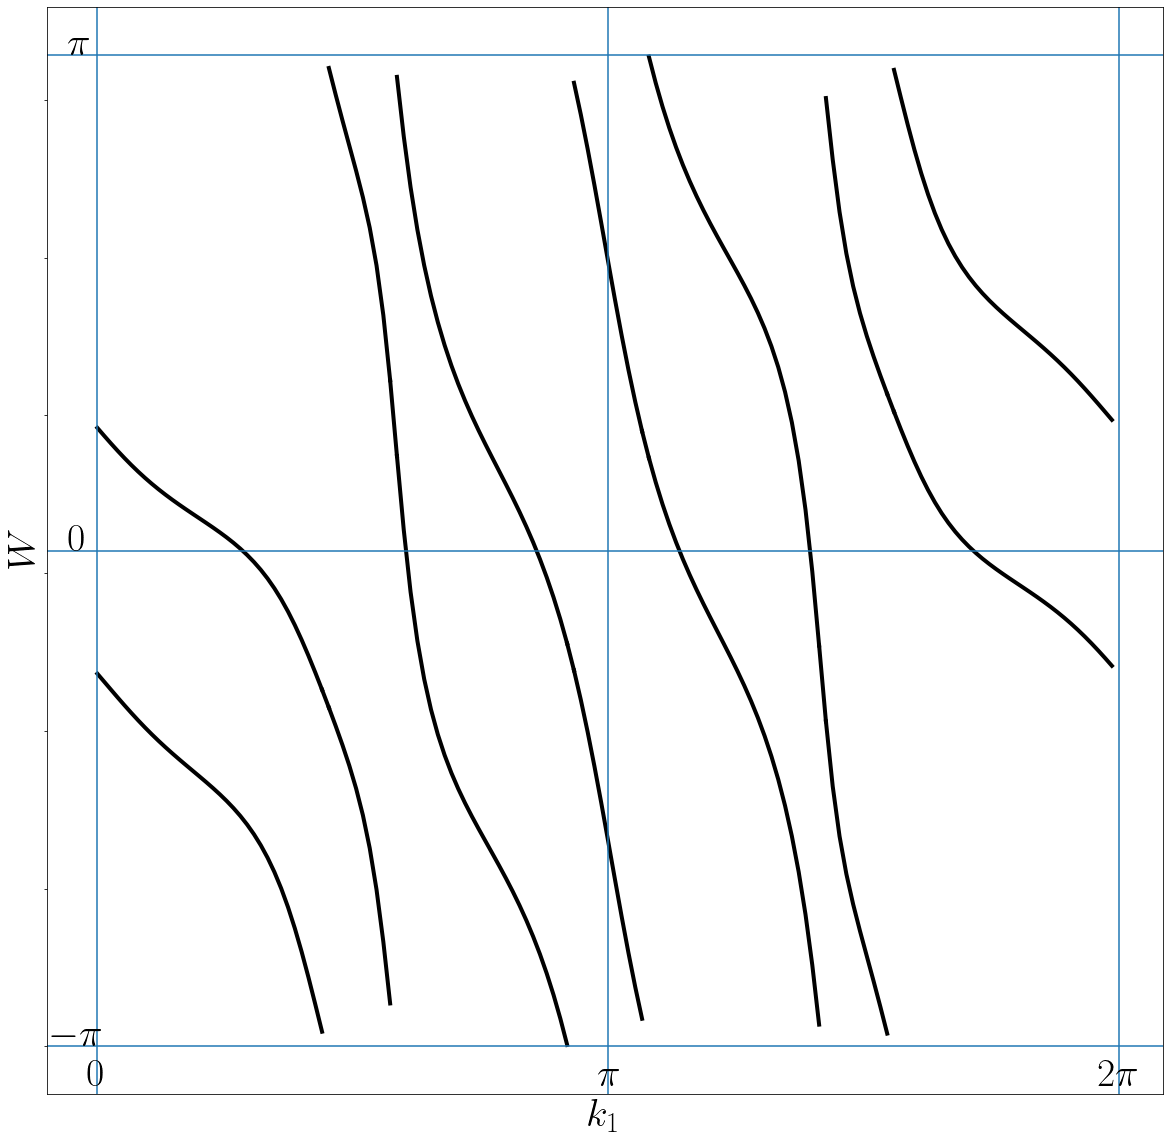

In [194]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)


plt.figure(figsize=(20,20))
frame1 = plt.gca()
plt.tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
plt.tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0]) + np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1]) + np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)

v0 = np.zeros(150)
v1 = np.zeros(150)

for i in range(150):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

plt.plot(range(150)[:34], v0[:34],c='black',linewidth=4) 
plt.plot(range(150)[:34], v1[:34],c='black',linewidth=4) 

plt.plot(range(150)[34:44], v0[34:44],c='black',linewidth=4) 
plt.plot(range(150)[34:44], v1[34:44],c='black',linewidth=4) 

plt.plot(range(150)[44:70], v0[44:70],c='black',linewidth=4) 
plt.plot(range(150)[44:70], v1[44:70],c='black',linewidth=4) 

plt.plot(range(150)[70:81], v0[70:81],c='black',linewidth=4) 
plt.plot(range(150)[70:81], v1[70:81],c='black',linewidth=4) 

plt.plot(range(150)[81:107], v0[81:107],c='black',linewidth=4) 
plt.plot(range(150)[81:107], v1[81:107],c='black',linewidth=4) 

plt.plot(range(150)[107:117], v0[107:117],c='black',linewidth=4) 
plt.plot(range(150)[107:117], v1[107:117],c='black',linewidth=4) 

plt.plot(range(150)[117:150], v0[117:150],c='black',linewidth=4) 
plt.plot(range(150)[117:150], v1[117:150],c='black',linewidth=4) 

plt.plot(range(150)[33:35], [v0[33],v1[34]],c='black',linewidth=4) 
plt.plot(range(150)[43:45], [v0[43],v1[44]],c='black',linewidth=4) 
plt.plot(range(150)[69:71], [v0[69],v1[70]],c='black',linewidth=4) 
plt.plot(range(150)[80:82], [v0[80],v1[81]],c='black',linewidth=4) 
plt.plot(range(150)[106:108], [v0[106],v1[107]],c='black',linewidth=4) 
plt.plot(range(150)[116:118], [v0[116],v1[117]],c='black',linewidth=4) 


plt.axhline(y=0)
plt.axhline(y=np.pi)
plt.axhline(y=2*np.pi)

plt.text(-6.75,0,r'$-\pi$',rotation=0)
plt.text(-4.25,np.pi,r'$0$',rotation=0)
plt.text(-4.25,2*np.pi,r'$\pi$',rotation=0)

plt.axvline(x=0)
plt.axvline(x=75)
plt.axvline(x=150)

plt.text(0-1.5,-0.25,r'$0$',rotation=0)
plt.text(75-1.5,-0.25,r'$\pi$',rotation=0)
plt.text(150-3,-0.25,r'$2\pi$',rotation=0)

plt.ylabel(r'$W$')
plt.xlabel(r'$k_1$')
    
plt.savefig('alongk1Changed_flat_D.png')

In [ ]:
for index, varia in enumerate([arrayOfwMp1, arrayOfwMp2, arrayOfwMm1, arrayOfwMm2]):
    plt.figure(figsize=(10,10))
    plt.scatter(range(50), np.mod(np.real(varia) + np.array([np.pi*(k/25.0) for k in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    plt.savefig('alongk1Changed_'+str(index)+'_B.png')
    plt.close()

In [21]:
listOfEigvalsWilson = []
listOfwMp1 = []
listOfwMp2 = []
listOfwMm1 = []
listOfwMm2 = []

for path in path_k2:
    wilsonMatrix,wMp1,wMp2,wMm1,wMm2 = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    listOfwMp1.append(-1.0j*np.log(wMp1))
    listOfwMp2.append(-1.0j*np.log(wMp2))
    listOfwMm1.append(-1.0j*np.log(wMm1))
    listOfwMm2.append(-1.0j*np.log(wMm2))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
arrayOfwMp1 = np.array(listOfwMp1)
arrayOfwMp2 = np.array(listOfwMp2)
arrayOfwMm1 = np.array(listOfwMm1)
arrayOfwMm2 = np.array(listOfwMm2)

In [22]:
np.save('path_k2_flat.npy',arrayOfEigvalsWilson)
np.save('path_k2_p1.npy',arrayOfwMp1)
np.save('path_k2_p2.npy',arrayOfwMp2)
np.save('path_k2_m1.npy',arrayOfwMm1)
np.save('path_k2_m2.npy',arrayOfwMm2)

In [23]:
#arrayOfEigvalsWilson=np.load('path_k2.npy')

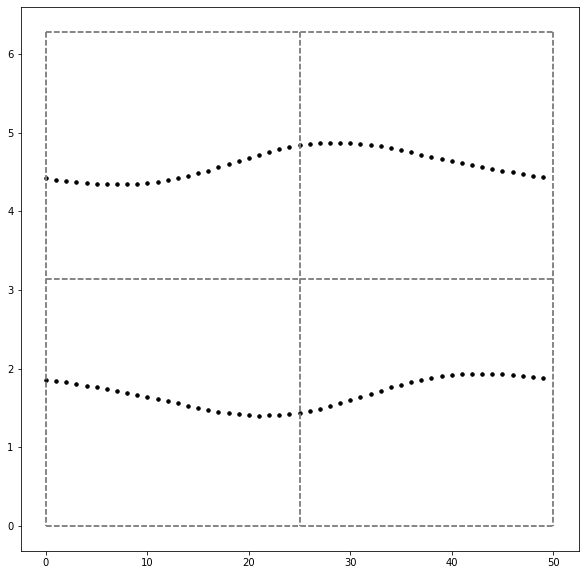

In [23]:
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(50), np.mod(np.real(arrayOfEigvalsWilson[:,i]) - np.array([np.pi*(i/25.0) for i in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
plt.savefig('alongk2Changed_flat.png')

In [24]:
for index, varia in enumerate([arrayOfwMp1, arrayOfwMp2, arrayOfwMm1, arrayOfwMm2]):
    plt.figure(figsize=(10,10))
    plt.scatter(range(50), np.mod(np.real(varia) - np.array([np.pi*(k/25.0) for k in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    plt.savefig('alongk2Changed_'+str(index)+'.png')
    plt.close()

In [27]:
listOfEigvalsWilson = []
listOfwMp1 = []
listOfwMp2 = []
listOfwMm1 = []
listOfwMm2 = []

for path in path_x:
    wilsonMatrix,wMp1,wMp2,wMm1,wMm2 = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    listOfwMp1.append(-1.0j*np.log(wMp1))
    listOfwMp2.append(-1.0j*np.log(wMp2))
    listOfwMm1.append(-1.0j*np.log(wMm1))
    listOfwMm2.append(-1.0j*np.log(wMm2))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
arrayOfwMp1 = np.array(listOfwMp1)
arrayOfwMp2 = np.array(listOfwMp2)
arrayOfwMm1 = np.array(listOfwMm1)
arrayOfwMm2 = np.array(listOfwMm2)


In [28]:
np.save('path_x_flat.npy',arrayOfEigvalsWilson)
np.save('path_x_p1.npy',arrayOfwMp1)
np.save('path_x_p2.npy',arrayOfwMp2)
np.save('path_x_m1.npy',arrayOfwMm1)
np.save('path_x_m2.npy',arrayOfwMm2)

In [27]:
#arrayOfEigvalsWilson = np.load('path_x.npy')

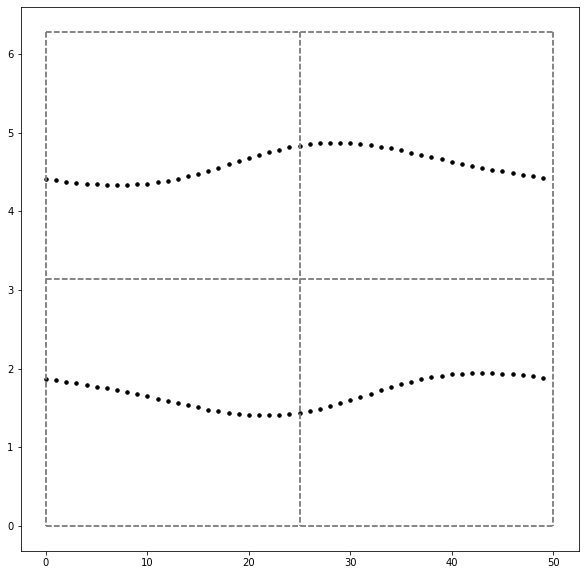

In [29]:
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(50), np.mod(np.real(arrayOfEigvalsWilson[:,i]) - np.array([np.pi*((i-25.0)/25.0) for i in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    
plt.savefig('alongxChanged_flat.png')

In [31]:
for index, varia in enumerate([arrayOfwMp1, arrayOfwMp2, arrayOfwMm1, arrayOfwMm2]):
    plt.figure(figsize=(10,10))
    plt.scatter(range(50), np.mod(np.real(varia)-np.array([np.pi*((k-25.0)/25.0) for k in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    plt.savefig('alongxChanged_'+str(index)+'.png')
    plt.close()

In [32]:
listOfEigvalsWilson = []
listOfwMp1 = []
listOfwMp2 = []
listOfwMm1 = []
listOfwMm2 = []

for path in path_y:
    wilsonMatrix,wMp1,wMp2,wMm1,wMm2 = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    listOfwMp1.append(-1.0j*np.log(wMp1))
    listOfwMp2.append(-1.0j*np.log(wMp2))
    listOfwMm1.append(-1.0j*np.log(wMm1))
    listOfwMm2.append(-1.0j*np.log(wMm2))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
arrayOfwMp1 = np.array(listOfwMp1)
arrayOfwMp2 = np.array(listOfwMp2)
arrayOfwMm1 = np.array(listOfwMm1)
arrayOfwMm2 = np.array(listOfwMm2)

In [33]:
np.save('path_y_flat.npy',arrayOfEigvalsWilson)
np.save('path_y_p1.npy',arrayOfwMp1)
np.save('path_y_p2.npy',arrayOfwMp2)
np.save('path_y_m1.npy',arrayOfwMm1)
np.save('path_y_m2.npy',arrayOfwMm2)

In [32]:
#arrayOfEigvalsWilson = np.load('path_y.npy')

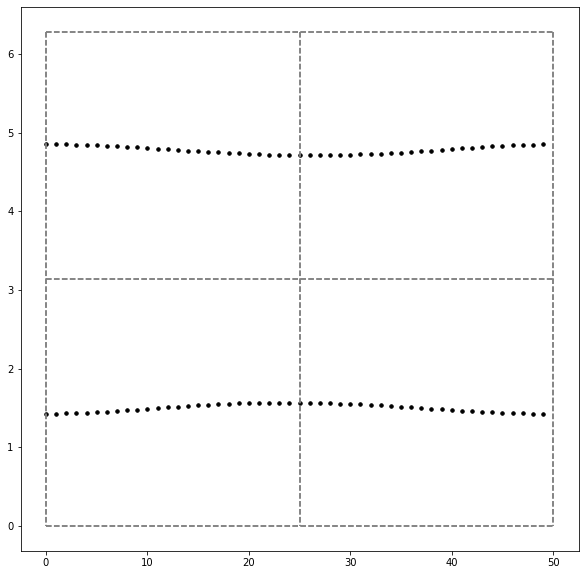

In [34]:
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(50), np.mod(np.real(arrayOfEigvalsWilson[:,i]) + np.array([np.pi*((i-25.0)/25.0) for i in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
plt.savefig('alongyChanged_flat.png')

In [35]:
for index, varia in enumerate([arrayOfwMp1, arrayOfwMp2, arrayOfwMm1, arrayOfwMm2]):
    plt.figure(figsize=(10,10))
    plt.scatter(range(50), np.mod(np.real(varia) + np.array([np.pi*((k-25.0)/25.0) for k in range(50)]),2*np.pi),s=12,c='black') 
    plt.plot([0,50],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,50],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,50],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([25,25],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    plt.savefig('alongyChanged_'+str(index)+'.png')
    plt.close()

In [36]:
listOfEigvalsWilson = []
listOfwMp1 = []
listOfwMp2 = []
listOfwMm1 = []
listOfwMm2 = []

for path in path_list:
    wilsonMatrix,wMp1,wMp2,wMm1,wMm2 = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    listOfwMp1.append(-1.0j*np.log(wMp1))
    listOfwMp2.append(-1.0j*np.log(wMp2))
    listOfwMm1.append(-1.0j*np.log(wMm1))
    listOfwMm2.append(-1.0j*np.log(wMm2))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
arrayOfwMp1 = np.array(listOfwMp1)
arrayOfwMp2 = np.array(listOfwMp2)
arrayOfwMm1 = np.array(listOfwMm1)
arrayOfwMm2 = np.array(listOfwMm2)

In [37]:
np.save('path_c3_flat.npy',arrayOfEigvalsWilson)
np.save('path_c3_p1.npy',arrayOfwMp1)
np.save('path_c3_p2.npy',arrayOfwMp2)
np.save('path_c3_m1.npy',arrayOfwMm1)
np.save('path_c3_m2.npy',arrayOfwMm2)

In [8]:
arrayOfEigvalsWilson = np.load('path_c3.npy')
arrayOfwMp1=np.load('path_c3_p1.npy')
arrayOfwMp2=np.load('path_c3_p2.npy')
arrayOfwMm1=np.load('path_c3_m1.npy')
arrayOfwMm2=np.load('path_c3_m2.npy')

In [9]:
c3phases = np.load('c3phases.npy')

In [10]:
approxPhases=0.5*np.array([c3phases[49] + (c3phases[49]-c3phases[9])/40.0*(j-49) for j in range(50)] \
            + [c3phases[49] + (c3phases[89]-c3phases[49])/40.0*(j) for j in range(50)])

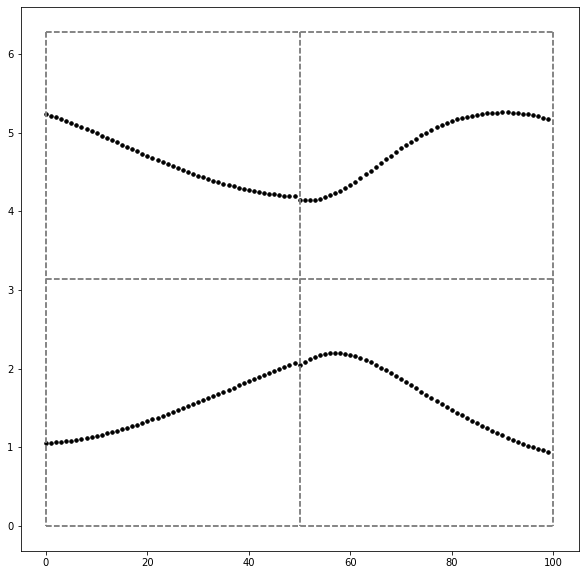

In [40]:
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(100), np.mod(np.real(arrayOfEigvalsWilson[:,i]+approxPhases),2*np.pi),s=12,c='black') 
    plt.plot([0,100],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,100],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,100],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    plt.plot([100,100],[2*np.pi,0],'--',c='gray')
plt.savefig('alongC3Changed_flat.png')

In [11]:
for index, varia in enumerate([arrayOfwMp1, arrayOfwMp2, arrayOfwMm1, arrayOfwMm2]):
    plt.figure(figsize=(10,10))
    plt.scatter(range(100), np.mod((np.real(varia+approxPhases)),2*np.pi),s=12,c='black') 
    plt.plot([0,100],[np.pi,np.pi],'--',c='gray')
    plt.plot([0,100],[2*np.pi,2*np.pi],'--',c='gray')
    plt.plot([0,100],[0,0],'--',c='gray')
    plt.plot([0,0],[2*np.pi,0],'--',c='gray')
    plt.plot([50,50],[2*np.pi,0],'--',c='gray')
    plt.plot([100,100],[2*np.pi,0],'--',c='gray')
    plt.savefig('alongC3Changed_'+str(index)+'.png')
    plt.close()

for i1 in range(500):    
    for j1 in range(500):
        k_vec = i1/500.0*b1 + j1/500.0*b2
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        np.save('./DatabaseOfWavefunctions/'+str(i1)+'_'+str(j1)+'.npy', u_matrix, allow_pickle=True, fix_imports=True)


In [64]:
def plotHexagon(points,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    newPoints = []
    for coords in points:
        len1 = np.dot(coords, hex1)
        len2 = np.dot(coords, hex2)
        len3 = np.dot(coords, hex3)
        if len1 < 0.5*dist+0.00005 and len2 < 0.5*dist+0.00005:
            newPoints.append(coords)
        elif len1 > dist and len2 > dist:
            newPoints.append(coords-l1-l2)
        elif len3 > 0:
            newPoints.append(coords-l2)
        else:
            newPoints.append(coords-l1)
            
    return(np.array(newPoints))

In [65]:
def inHexagon(pointsx,pointsy,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    matrixOfVals = np.zeros(np.shape(pointsx))
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    inside = []
    for i in range(len(pointsx)):
        for j in range(len(pointsx[0])):
            matrixOfVals[i][j] = 0
            coords = np.array([pointsx[i][j],pointsy[i][j]])
            len1 = np.dot(coords, hex1)
            len2 = np.dot(coords, hex2)
            len3 = np.dot(coords, hex3)
            if len1 < np.sqrt(3)/2 and len1 > -np.sqrt(3)/2:
                if len2 < np.sqrt(3)/2 and len2 > -np.sqrt(3)/2:
                    if len3 < np.sqrt(3)/2 and len3 > -np.sqrt(3)/2:
                        matrixOfVals[i][j] = 1.0
    return(matrixOfVals)

In [69]:
query=plotHexagon(path_list[0],b1,b2)
query2=plotHexagon(path_list[25],b1,b2)
query3=plotHexagon(path_list[49],b1,b2)
query4=plotHexagon(path_list[50],b1,b2)
query5=plotHexagon(path_list[75],b1,b2)
query6=plotHexagon(path_list[99],b1,b2)


In [117]:
path_k1

[[array([0.+0.j, 0.+0.j]),
  array([ 0.01732051+0.j, -0.03      +0.j]),
  array([ 0.03464102+0.j, -0.06      +0.j]),
  array([ 0.05196152+0.j, -0.09      +0.j]),
  array([ 0.06928203+0.j, -0.12      +0.j]),
  array([ 0.08660254+0.j, -0.15      +0.j]),
  array([ 0.10392305+0.j, -0.18      +0.j]),
  array([ 0.12124356+0.j, -0.21      +0.j]),
  array([ 0.13856406+0.j, -0.24      +0.j]),
  array([ 0.15588457+0.j, -0.27      +0.j]),
  array([ 0.17320508+0.j, -0.3       +0.j]),
  array([ 0.19052559+0.j, -0.33      +0.j]),
  array([ 0.2078461+0.j, -0.36     +0.j]),
  array([ 0.2251666+0.j, -0.39     +0.j]),
  array([ 0.24248711+0.j, -0.42      +0.j]),
  array([ 0.25980762+0.j, -0.45      +0.j]),
  array([ 0.27712813+0.j, -0.48      +0.j]),
  array([ 0.29444864+0.j, -0.51      +0.j]),
  array([ 0.31176915+0.j, -0.54      +0.j]),
  array([ 0.32908965+0.j, -0.57      +0.j]),
  array([ 0.34641016+0.j, -0.6       +0.j]),
  array([ 0.36373067+0.j, -0.63      +0.j]),
  array([ 0.38105118+0.j, -0.66 

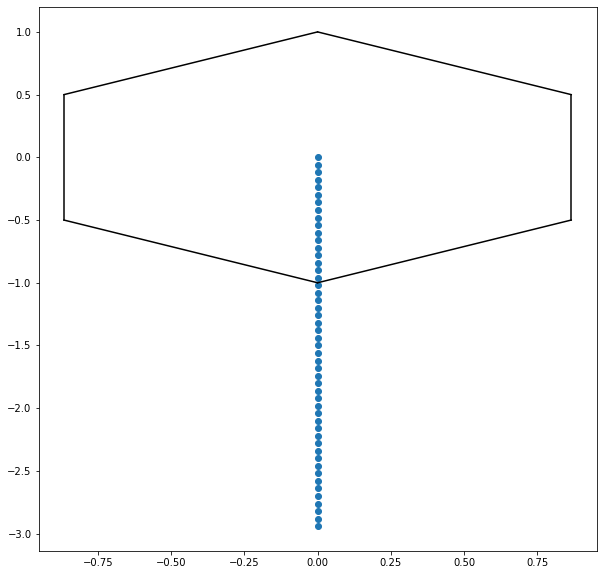

In [147]:
# plots of the C3 invariant paths

plt.figure(figsize=(10,10))

plt.plot([np.real(q1[0]),np.real(q1[0]+q3[0])],[np.real(q1[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q1[0]+q3[0])],[np.real(q3[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q2[0]+q3[0])],[np.real(q3[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q3[0])],[np.real(q2[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q1[0])],[np.real(q2[1]),np.real(q2[1]+q1[1])],c='black')
plt.plot([np.real(q1[0]),np.real(q2[0]+q1[0])],[np.real(q1[1]),np.real(q2[1]+q1[1])],c='black')
array_path=np.real(np.array(path_y))
plt.scatter(array_path[0,:,0],array_path[0,:,1])

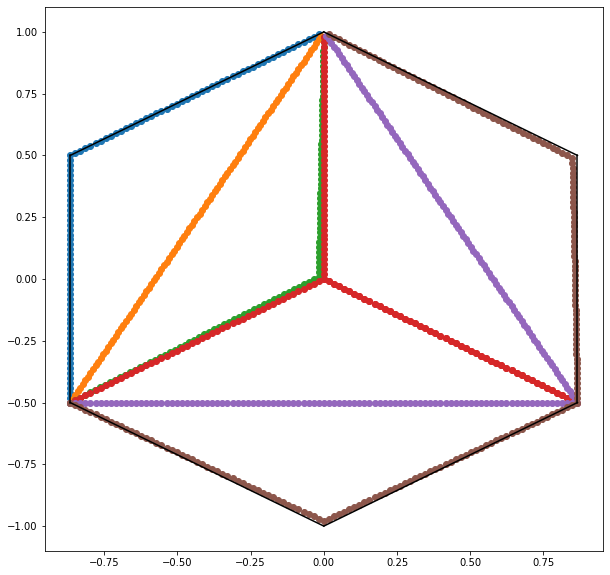

In [71]:
# plots of the C3 invariant paths

plt.figure(figsize=(10,10))

plt.plot([np.real(q1[0]),np.real(q1[0]+q3[0])],[np.real(q1[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q1[0]+q3[0])],[np.real(q3[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q2[0]+q3[0])],[np.real(q3[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q3[0])],[np.real(q2[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q1[0])],[np.real(q2[1]),np.real(q2[1]+q1[1])],c='black')
plt.plot([np.real(q1[0]),np.real(q2[0]+q1[0])],[np.real(q1[1]),np.real(q2[1]+q1[1])],c='black')

plt.scatter(query[:,0],query[:,1])
plt.scatter(query2[:,0],query2[:,1])
plt.scatter(query3[:,0],query3[:,1])
plt.scatter(query4[:,0],query4[:,1])
plt.scatter(query5[:,0],query5[:,1])
plt.scatter(query6[:,0],query6[:,1])

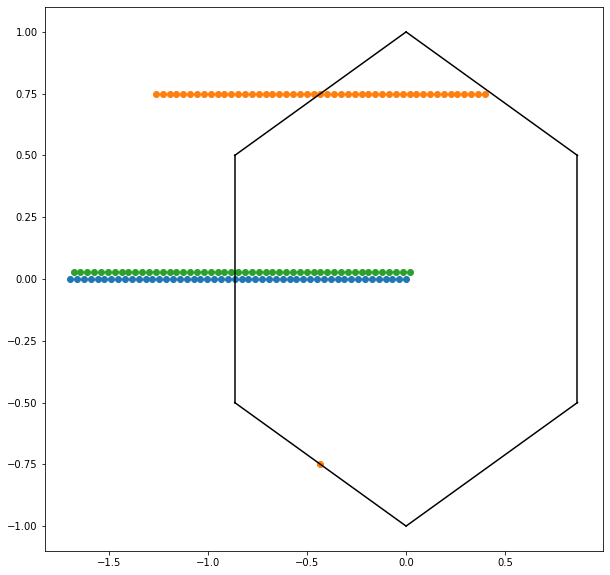

In [130]:
path_x
query=plotHexagon(path_x[0],b1,b2)
query2=plotHexagon(path_x[25],b1,b2)
query3=plotHexagon(path_x[49],b1,b2)

plt.figure(figsize=(10,10))

plt.plot([np.real(q1[0]),np.real(q1[0]+q3[0])],[np.real(q1[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q1[0]+q3[0])],[np.real(q3[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q2[0]+q3[0])],[np.real(q3[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q3[0])],[np.real(q2[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q1[0])],[np.real(q2[1]),np.real(q2[1]+q1[1])],c='black')
plt.plot([np.real(q1[0]),np.real(q2[0]+q1[0])],[np.real(q1[1]),np.real(q2[1]+q1[1])],c='black')

plt.scatter(query[:,0],query[:,1])
plt.scatter(query2[:,0],query2[:,1])
plt.scatter(query3[:,0],query3[:,1])

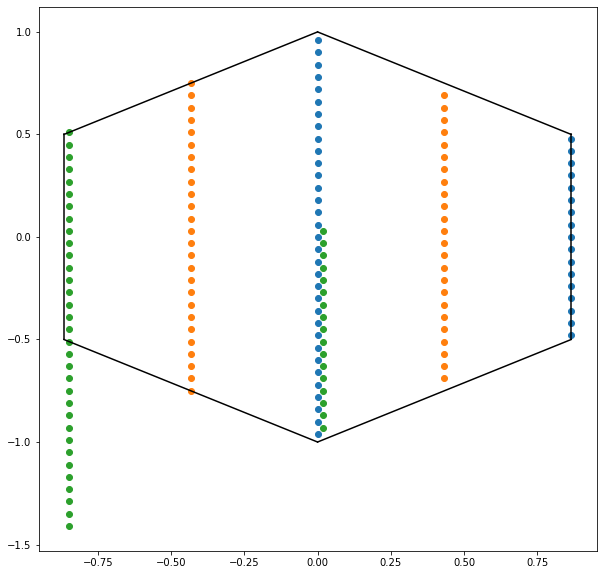

In [131]:
path_x
query=plotHexagon(path_y[0],b1,b2)
query2=plotHexagon(path_y[25],b1,b2)
query3=plotHexagon(path_y[49],b1,b2)

plt.figure(figsize=(10,10))

plt.plot([np.real(q1[0]),np.real(q1[0]+q3[0])],[np.real(q1[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q1[0]+q3[0])],[np.real(q3[1]),np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(q3[0]),np.real(q2[0]+q3[0])],[np.real(q3[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q3[0])],[np.real(q2[1]),np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(q2[0]),np.real(q2[0]+q1[0])],[np.real(q2[1]),np.real(q2[1]+q1[1])],c='black')
plt.plot([np.real(q1[0]),np.real(q2[0]+q1[0])],[np.real(q1[1]),np.real(q2[1]+q1[1])],c='black')

plt.scatter(query[:,0],query[:,1])
plt.scatter(query2[:,0],query2[:,1])
plt.scatter(query3[:,0],query3[:,1])